# Starbucks Capstone Challenge Notebook

%%latex

## Background : 

The businesses want to target right customers throughout the customer journey which helps to reduce the marketing budget, customer satisfaction as well increase the profits.  Machine learning (ML) and artificial intelligence (AI) technologies are helping automate the digital marketing with real time decision making such as selecting best messaging platform, best timing, and the best offering to the individual customer by integrating data from different platforms \cite{linkedin,digitalmarketinginstitute,urbancursor,medium}.

Udacity's Starbucks Capstone challenge project  data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Machine learning technique will be used in order to develop effective marketing strategy for the Starbucks business using the available data.  


# Problem Statement 

Starbucks sends out an offer to users of the mobile app every few days. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The given dataset contains demographic data a record of transaction and details about offer information. Before developing a predictive model, exploratory data analysis and customer segmentation will be carried out which will help Starbucks business in better targeted marketing.  

\textit{It is important to know your customers in order to increase business. First, customer segmentation using unsupervised machine learning technique K-means clustering will be carried out to understand current customer characteristics and demographics. Second  the best performing supervised machine learning model will be build by comparing random forest and boosting ensemble models performance based on the defined metrics to predict if customer will respond to an offer or not for better targeted marketing. }


# Project Design 

Following are the project design steps carried out to execute this project

## Part I 
- Data Exploration & : First step is to know the data. Matplotlib/Seaborn/plotly libraries will be used for the exploratory data analysis (EDA). Study the data statistic, count missing values, plot different variables and understand and explore the data.
- Model pre-processing and cleaning : Basic cleaning steps such as filling missing, checking outliers, dropping unimportant and duplicate columns, Encoding categorical variables..
## Part II
 Data Wranglling -  scaling, and feature engineering. 
## Part II
- Next, customer segmentation will be carried out to group the demographic and purchase data.  
- Train and Test data : Labeled dataset will be prepared and split randomly to train and test dataset. 
## Part III
- Model training and implementation : Five different models will be implemented and based on the AUC value and other metrics, best model will be selected. 
- Model validation : Test data will be used to validate the model performance with defined metrics. 
- Model selection and optimization : Selected model will be tuned using a grid search. 
    
# Challanges 

- Not all users receive the same offer
- Different validity period the offer type and informational offer to influence customer.
- Customer might make a purchase through the app without having received an offer or seen an offer
- A user can receive an offer, never actually view the offer, and still complete the offer


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Reference
https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby/45925961
https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
https://stackoverflow.com/questions/50522146/pandas-column-dict-split-to-new-column-and-rows
https://stackoverflow.com/questions/56421683/how-to-apply-a-function-for-each-row-of-a-dataframe-which-checks-keys-of-embedd
https://stackoverflow.com/questions/41455967/convert-datetime-string-to-new-columns-of-day-month-year-in-pandas-data-frame/41456152

https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime-dd-mm-yyyy-format

https://stackoverflow.com/questions/49742938/checking-isdigit-on-python
 https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib
#% matplotlib inline|



# Part 1 :  Initial Dataset Statistics and basic EDA



## summary of portfolio statistics
- profile dataframe has age, gender catgorical features which we will need to encode
- become member on need to be changed to membership years.
- age max value 118 - looks like outlier
- only income and gender columns have more missing values - 2175 which are corresponding to age outlier. We will check overall missing values in the combined dataset to decided if we need to impute or delete missing values.



def basic_EDA(df):
    

def plot_hist(df)



In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)

# Check size of the data set
print('portfolio  shape is {}:' .format(portfolio.shape)) 



portfolio  shape is (10, 6):


In [3]:
# Check size of the basic statistics
print('portfolio statistics  {}:' .format(portfolio.describe())) 
print('portfolio null count {}:' .format(portfolio.isnull().sum())) 
 

portfolio statistics         difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000:
portfolio null count channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64:


In [4]:
print('portfolio data   {}:' .format(portfolio.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
portfolio data   None:


In [5]:
# cleaning function portfolio
# credit -  https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# credit - https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
# credit -https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list/45312577#45312577

def portfolio_clean(portfolio):

    """ 
    Clean, select and transform a DataFrame containing information about offer type and duration
    INPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        portfolio: clean transformed portfolio DataFrame
    """  
    
   # portfolio = portfolio.assign(**pd.get_dummies(portfolio.channels.apply(lambda x:pd.Series(x)).stack()
                                                    #.reset_index(level=1,drop=True)).sum(level=0))
    #portfolio = portfolio.assign(**pd.get_dummies(portfolio.offer_type.apply(lambda x:pd.Series(x)).stack()
                                                   # .reset_index(level=1,drop=True)).sum(level=0))
    #portfolio['id'] = [offer_id_col[item] for item in portfolio_df['id']] 
    portfolio.rename(columns={'id':'offer_id', 'reward': 'reward_offered'}, inplace =True)
    
    #offer_type_col = {'bogo':'1', 'informational':'2','discount':'3'}
    #portfolio['offer_type'] = [offer_type_col[item] for item in portfolio['offer_type']] 
    
    portfolio.drop(['channels'], axis=1, inplace=True)
    
    return portfolio



In [6]:
portfolio_df=portfolio_clean(portfolio)

In [7]:
portfolio_df.head()

,difficulty,duration,offer_id,offer_type,reward_offered
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## summary of profile statistics
- profile dataset
-
-

In [8]:
# read in the json files

profile = pd.read_json('profile.json', orient='records', lines=True)
# Check size of the data set
print('profile  shape is {}:' .format(profile.shape)) 
 


profile  shape is (17000, 5):


In [9]:
print('profile statistics  {}:' .format(profile.describe())) 
print('profile data   {}:' .format(profile.info())) 
print('profile null count{}:' .format(profile.isnull().sum()))

profile statistics                  age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
profile data   None:
profile null countage                    0
became_member_on       0
gender              2175
id     

In [13]:
# cleaning function profile
# credit -  https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
import datetime

def profile_clean(profile):

    """ 
    Clean, select and transform a DataFrame containing a demographic data for each customer
    INPUT:
        profile: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        profile: clean and transformed profile DataFrame
    """  
    #profile['date_time']  = profile[['became_member_on']].applymap(str).applymap(lambda s: "{}/{}/{}"
                                                                                # .format( s[0:4],s[4:6],s[6:]))
        # We can calculate membershipt years using became member on data to see how long customer is starbucks member
    profile['date_time'] =pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
    end_time =(datetime.datetime.today().date())
    start_time =(profile['date_time'].dt.date)
    
    profile['membership_years']=  (end_time -start_time)
    profile['membership_years'] = round((pd.to_numeric(profile['membership_years'].dt.days, downcast='integer'))/365,2)
   
                            
    # only gender and income column showed nan values. We will clean the data # dropped data comment
    profile= profile.dropna(axis=0, subset=['gender'])
    
    # keep only year unless want to calculate membership period then we may need month and date 
    profile['year'] = pd.DatetimeIndex(profile['date_time']).year   

    profile.rename(columns={'id':'customer_id'}, inplace =True)
    profile.drop(['date_time', 'became_member_on'], axis=1,inplace=True)

    return profile


In [14]:
profile_df=profile_clean(profile)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
profile_df.head()

,age,gender,customer_id,income,membership_years,year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2.67,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2.85,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1.88,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2.09,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2.34,2017



## summary of transcript statistics
- transcript dataframe
-b
-a
-c
-d




In [16]:
# read in the json files
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Check size of the data set
print('transcript  shape is {}: ' .format(transcript.shape)) 


transcript  shape is (306534, 4): 


In [17]:
print('transcript statistics  {}:' .format(transcript.describe())) 

print('transcript data   {}:' .format(transcript.info()))  

print('transcript null count{}: ' .format(transcript.isnull().sum())) 

transcript statistics                  time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
transcript data   None:
transcript null countevent     0
person    0
time      0
value     0
dtype: int64: 


In [108]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [107]:
# transcript value contains amount related to transaction, offer id and reward given 
transcript.tail(5)

,event,customer_id,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [18]:
# cleaning function transcript
# credit - https://stackoverflow.com/questions/58383927/convert-series-of-dict-and-concat-to-dataframe
#https://stackoverflow.com/questions/38134012/pandas-dataframe-fillna-only-some-columns-in-place

def transcript_clean(transcript):

    """ 
    Clean, select and transform a DataFrame containing the records for transactions,
    offer types : received, viewed, completed
    INPUT:
        transcript: DataFrame containing records of transaction, customer id, time and value
                   each offer (duration, type, etc.)
    OUTPUT:
        transcript: clean and transformed transcript DataFrame
    """  
    # value column contains disctionary with amount, reward and offer id 
    # it results in nan columns which we will clean later
    transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
   # transcript = transcript.assign(**pd.get_dummies(transcript.event.apply(lambda x:pd.Series(x)).stack()
                                                   # .reset_index(level=1,drop=True)).sum(level=0))
    
    # we will delete offer_id column , it contains duplicate/missing information from offer id related to reward - 
    #we can fill that information from offer_id column - reward offer id
    transcript['offer_id'].fillna(transcript['offer id'],inplace=True)
    transcript.rename(columns={'person':'customer_id', 'reward':'reward_given'}, inplace =True)
    
    #convert number of days - time column to 
    transcript['time'] = round(transcript['time']/24).astype(int)
    #transcript= pd.concat([transcript, pd.get_dummies(transcript['event'])], axis= 1)
    transcript.drop(['value', 'offer id'], axis=1,inplace=True)

    return transcript

In [19]:
transcript_df=transcript_clean(transcript)

In [20]:
transcript_df.head()

,event,customer_id,time,amount,offer_id,reward_given
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Missing Value Analysis 
Rule of thumb, if there is less than 5% of missing data and features are not important then we can delete. However, We have almost 12.79% missing customer profile. It belongs to gender and income  columns.

To further understand mising data : We will have closer look at the combined dataframe. We can check that how it can affect overall segmentation analysis and offer predictions modeling. 
Total trasaction - 306534
total completed offer with nan gender and age/total trasaction = 3.37% missing data 
checking how many transactions for income and age data with missing values = 10.79%


It is recommonded to impute data with mean or median values or predict the missing value. 
Howeverm We will delete these values, since offer related missing trasaction data is less than 5%. 

https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca

In [29]:
print('Missing data percentage in the profile dataset ')
print(profile.isna().sum()*100/(len(profile)))

Missing data percentage in the profile dataset 
age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
date_time            0.000000
membership_years     0.000000
dtype: float64


In [33]:
df_merged=pd.merge(transcript_df, profile_df, on='customer_id', how='left')

In [34]:
df_merged.head()

,event,customer_id,time,amount,offer_id,reward_given,age,gender,income,membership_years,year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,2.85,2017.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,1.88,2018.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# We will lose very less offer related information. 
temp_1=df_merged[(df_merged['gender'].isna())&(df_merged['event']=='offer completed')]
temp_2 = df_merged[(df_merged['event']=='offer completed')]
print('missing offer completed data :',(len(temp_1)*100)/(len(temp_2)))

missing offer completed data : 3.3800887459424045


In [40]:
temp_3 = df_merged[(df_merged['gender'].isna())&(df_merged['event']=='transaction')]
temp_4 = df_merged[(df_merged['event']=='transaction')]
print('missing  trasaction data :',(len(temp_3)*100)/(len(temp_4)))


missing  trasaction data : 10.79213834893813


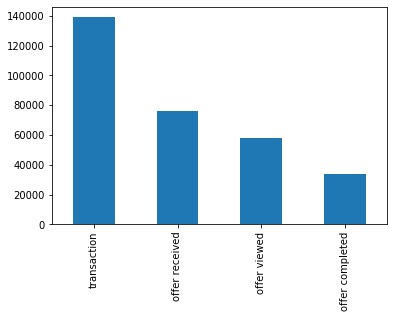

In [41]:
transcript['event'].value_counts().plot.bar()

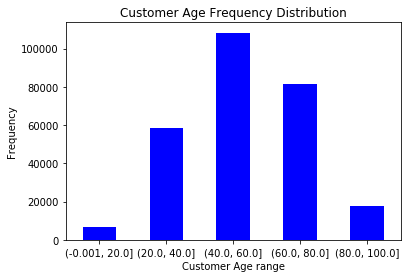

In [42]:
#https://stackoverflow.com/questions/43005462/pandas-bar-plot-with-binned-range
# plot function everything together
import seaborn as sns
age_bin = pd.cut(df_merged['age'], bins=[0, 20, 40, 60, 80,100], include_lowest=True)

ax = age_bin.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([ c[1:-1].replace(","," to") for c in age_bin.cat.categories])
plt.xlabel('Customer Age range')
plt.ylabel('Frequency')
plt.title('Customer Age Frequency Distribution')
plt.show()

## Part II
  scaling, and feature engineering. 


offer_completion_rate = Number of completed offers trasaction / Number of offers sent (all offers sum)
# Lets check how many offer related transaction
54% of data will be used to charecterize demographic#http://fluidsurveys.com/university/difference-response-rate-completion-rate/
# offer completion rate 
#df_temp2['offer_completion_rate'] =

In [61]:
# lets answer above discussed questions 

print('How many transaction are related to offer sent to the customer')
print(len(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].notnull())]))

print('How many customers did not respond to the sent offer')
print(len(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].isnull()) & transcript_df['reward_given'].isnull()]))
# may contain informational related transaction
print('How many customers transaction were not offer related')
print(len(transcript_df[(transcript_df['amount'].notnull())]))





How many transaction are related to offer sent to the customer
33579
How mant customers did not respond to the sent offer
134002
How many customers transaction were not offer related
138953


In [113]:
# check offer type and events count
transcript_temp = transcript_df.merge(portfolio_df,how='left',on='offer_id')

transcript_temp.groupby(['event','offer_type'])['offer_type'].count()

print(transcript_temp.groupby(['event'])['amount'].count().sum())

138953


In [117]:
# check transations with amount. 
transcript_temp.groupby(['event'])['amount'].count().sum()

138953

In [118]:
df_temp=pd.merge(transcript_df, portfolio_df, on='offer_id', how='left')
#df_merged=pd.merge(df_temp, portfolio_df, on='offer_id', how='left')

df_temp.head()

,event,customer_id,time,amount,offer_id,reward_given,difficulty,duration,offer_type,reward_offered
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,10.0


In [124]:

df_temp.groupby('offer_type')['reward_given'].count()

offer_type
bogo             15669
discount         17910
informational        0
Name: reward_given, dtype: int64

In [196]:
# we need to find informatial award related transation later
print(len(df_temp[df_temp['offer_type']=='informational'].groupby('customer_id').event.value_counts().unstack()))

10547

In [180]:

informational_offer= df_temp[df_temp['offer_type']=='informational'].groupby('customer_id').event.value_counts().unstack()
informational_offer.reset_index(drop=False,inplace=True)
informational_offer=informational_offer.fillna(0)
informational_offer.rename_axis(None, axis=1,inplace =True)
informational_offer.rename(columns={'offer received': 'offer_received_informational' , 
                                    'offer viewed': 'offer_viewed_informational'},inplace =True)


discount_offer=df_temp[df_temp['offer_type']=='discount'].groupby('customer_id').event.value_counts().unstack()
discount_offer.reset_index(drop=False,inplace=True)
discount_offer=discount_offer.fillna(0)
discount_offer.rename_axis(None, axis=1,inplace =True)
discount_offer.rename(columns={'offer completed': 'offer_completed_discount','offer received':'offer_recieved_discount',
                               'offer viewed': 'offer_viewed_discount'},inplace =True)



bogo_offer=df_temp[df_temp['offer_type']=='bogo'].groupby('customer_id').event.value_counts().unstack()
bogo_offer.reset_index(drop=False,inplace=True)
bogo_offer=discount_offer.fillna(0)
bogo_offer.rename_axis(None, axis=1,inplace =True)
bogo_offer.rename(columns={'offer completed': 'offer_completed_bogo','offer received': 'offer_recieved_bogo',
                               'offer viewed': 'offer_viewed_bogo'},inplace =True)

In [181]:
informational_offer.head()

,customer_id,offer_received_informational,offer_viewed_informational
0,0009655768c64bdeb2e877511632db8f,2.0,2.0
1,0011e0d4e6b944f998e987f904e8c1e5,2.0,2.0
2,0020c2b971eb4e9188eac86d93036a77,1.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,2.0,2.0


In [182]:
discount_offer.head()

,customer_id,offer_completed_discount,offer_recieved_discount,offer_viewed_discount
0,0009655768c64bdeb2e877511632db8f,2.0,2.0,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,2.0,2.0,2.0
2,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,3.0,3.0,2.0


In [183]:
bogo_offer.head()

,customer_id,offer_completed_discount,offer_recieved_discount,offer_viewed_discount
0,0009655768c64bdeb2e877511632db8f,2.0,2.0,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,2.0,2.0,2.0
2,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,3.0,3.0,2.0


In [184]:
# count bogo, discount and informational  offer received by customer
offer_received = df_temp[df_temp['event']=='offer received'].groupby('customer_id').offer_type.value_counts().unstack()
offer_received.reset_index(drop=False,inplace=True)
offer_received=offer_received.fillna(0)
offer_received.rename_axis(None, axis=1,inplace =True)
offer_received['total_offer_recieved'] = offer_received['bogo'] + offer_received['discount']+offer_received['informational']
offer_received['total_off_recev_bo_dis'] = offer_received['bogo'] + offer_received['discount']


offer_received.rename(columns={'bogo':'offer_recieved_bogo', 'discount':'offer_recieved_discount',
                                    'informational': 'offer_recieved_informational'},inplace =True)

In [185]:
offer_received.head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0


In [166]:
#count offer completed by each customer
offer_completed =df_temp[df_temp['event']=='offer completed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_completed.reset_index(drop=False,inplace=True)
offer_completed=offer_completed.fillna(0)
offer_completed.rename_axis(None, axis=1,inplace =True)
offer_completed['total_offer_completed'] = offer_completed['bogo'] + offer_completed['discount']
offer_completed.rename(columns={'bogo':'offer_completed_bogo', 'discount':'offer_completed_discount'}, inplace =True)


#count ho many offers viewed by each customer
offer_viewed =df_temp[df_temp['event']=='offer viewed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_viewed.reset_index(drop=False,inplace=True)
offer_viewed=offer_viewed.fillna(0)
offer_viewed['total_offer_viewed'] = offer_viewed['bogo'] + offer_viewed['discount']+offer_viewed['informational']
offer_viewed['total_off_viewed_bo+dis'] = offer_viewed['bogo'] + offer_viewed['discount']
offer_viewed['total_off_viewed_informational'] = offer_viewed['total_offer_viewed']-offer_viewed['total_off_viewed_bo+dis'] 
offer_viewed.rename(columns={'bogo':'offer_viewed_bogo', 'discount':'offer_viewed_discount',
                                    'informational': 'offer_viewed_informational'},inplace =True)



df_temp2=pd.merge(offer_received,offer_viewed,on='customer_id',how='left')
df_temp3=pd.merge(df_temp2,offer_completed, on='customer_id',how='left')

In [167]:
df_temp3.head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,total_off_viewed_informational,offer_completed_bogo,offer_completed_discount,total_offer_completed
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0,3.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,3.0


In [203]:
df_temp3['no_offer'] = np.where(df_temp3['total_offer_completed'].isnull(), 1, 0)
print('transaction only customers : {}'.format(df_temp3['no_offer'].sum()))

transaction only customers : 4220


In [204]:
df_temp3.fillna(0).head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,total_off_viewed_informational,offer_completed_bogo,offer_completed_discount,total_offer_completed,no_offer
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0,3.0,0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0,0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,3.0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,3.0,0


In [205]:

# offer view rate - all type of offer sent and viewed to check how much effective 
df_temp3['offer_view_rate']= df_temp3['total_offer_viewed']/df_temp3['total_offer_recieved']
# how
df_temp3['offer_completion_rate']=df_temp3['total_offer_completed']/df_temp3['total_off_recev_bo_dis']
#
df_temp3['bogo_completion_rate']=df_temp3['offer_completed_bogo']/df_temp3['offer_recieved_bogo']
#
df_temp3['discount_completion_rate']=df_temp3['offer_completed_discount']/df_temp3['offer_recieved_discount']
# informational offer completion rate - if transaction followed by informational offer
df_temp3['informational_view_rate']=df_temp3['offer_viewed_informational']/df_temp3['offer_recieved_informational']
# we will calculate total_offer_completion_rate after we obtaine informational offer 

df_temp3.fillna(0).head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,total_off_viewed_informational,offer_completed_bogo,offer_completed_discount,total_offer_completed,no_offer,offer_view_rate,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,...,2.0,1.0,2.0,3.0,0,0.8,1.00,1.0,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1,1.0,0.00,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,...,2.0,1.0,2.0,3.0,0,1.0,1.00,1.0,1.0,1.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,...,1.0,1.0,2.0,3.0,0,0.6,0.75,0.5,1.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,...,1.0,2.0,1.0,3.0,0,1.0,1.00,1.0,1.0,1.0


In [ ]:
df_customer.loc[df_customer['customer_id'] =='78afa995795e4d85b5d9ceeca43f5fef',:].reset_index(drop=True).head()

In [231]:
# encode event column to obtain new features from offer related transaction and non offer related transaction
transcript_df = transcript_df.assign(**pd.get_dummies(transcript.event.apply(lambda x:pd.Series(x)).stack()
                                                    .reset_index(level=1,drop=True)).sum(level=0))




In [246]:
# calculate total transaction amount for each customer.
temp1=df_temp.groupby('customer_id').amount.sum().to_frame().reset_index()
temp1.rename(columns={'amount':'total_transaction_amount'},inplace=True)
# calculate total transaction count for each customer
temp2=df_temp[df_temp['event']=='transaction'].groupby('customer_id').event.count().to_frame().reset_index()
temp2.rename(columns={'event':'total_transaction_count'},inplace=True)
#calculate total reward given to each customer
temp3 = df_temp.groupby('customer_id').reward_given.sum().to_frame().reset_index()
temp3.rename(columns={'reward_given':'total_reward_given'},inplace=True)
# calculate total offer related transaction count 
#temp4=df_temp[(transcript_dummy['transaction']==1)&((transcript_dummy['offer completed']==1))].groupby('customer_id').event.count().to_frame().reset_index()
#temp4.rename(columns={'event':'total_transaction_count'},inplace=True)

In [ ]:
len(temp2)

In [270]:
#https://stackoverflow.com/questions/52223045/merge-multiple-dataframes-based-on-a-common-column
from functools import reduce
demographic_df=reduce(lambda x,y: pd.merge(x,y, on='customer_id', how='outer'), [df_temp3,temp1, temp2, temp3])

# we will deal with information offer related transaction later
demographic_df['regular_transaction_count'] = demographic_df['total_transaction_count']-demographic_df['total_offer_completed']
demographic_df['regular_transaction_count_rate']=demographic_df['regular_transaction_count']/demographic_df['total_transaction_count']
demographic_df['offer_transaction_count_rate']=(demographic_df['total_transaction_count']-demographic_df['regular_transaction_count']
                                               )/demographic_df['total_transaction_count']
#demographic_df'[offer_visibilty]' = offers viewed/offers recieved

demographic_df.shape

(17000, 27)

In [271]:
# we will flag transaction occured without offer. 
demographic_df['no_offer_trans'] = np.where(demographic_df['total_offer_completed'].isnull(), 1, 0)


In [272]:
transaction_customers_df=demographic_df[demographic_df['total_offer_completed'].isnull()].groupby('customer_id')
len(transaction_customers_df)

4226

In [273]:
offer_customers_df=demographic_df[demographic_df['total_offer_completed'].notnull()].groupby('customer_id')
len(offer_customers_df)

12774

In [274]:
12774+4226

17000

In [275]:
demographic_df.fillna(0).head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,bogo_completion_rate,discount_completion_rate,informational_view_rate,total_transaction_amount,total_transaction_count,total_reward_given,regular_transaction_count,regular_transaction_count_rate,offer_transaction_count_rate,no_offer_trans
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,...,1.0,1.0,1.0,127.60,8.0,9.0,5.0,0.625,0.375,0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,4.09,3.0,0.0,0.0,0.000,0.000,1
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,...,1.0,1.0,1.0,79.46,5.0,13.0,2.0,0.400,0.600,0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,...,0.5,1.0,1.0,196.86,8.0,14.0,5.0,0.625,0.375,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,...,1.0,1.0,1.0,154.05,12.0,13.0,9.0,0.750,0.250,0


In [276]:
demographic_df.columns

Index(['customer_id', 'offer_recieved_bogo', 'offer_recieved_discount',
       'offer_recieved_informational', 'total_offer_recieved',
       'total_off_recev_bo_dis', 'offer_viewed_bogo', 'offer_viewed_discount',
       'offer_viewed_informational', 'total_offer_viewed',
       'total_off_viewed_bo+dis', 'total_off_viewed_informational',
       'offer_completed_bogo', 'offer_completed_discount',
       'total_offer_completed', 'no_offer', 'offer_view_rate',
       'offer_completion_rate', 'bogo_completion_rate',
       'discount_completion_rate', 'informational_view_rate',
       'total_transaction_amount', 'total_transaction_count',
       'total_reward_given', 'regular_transaction_count',
       'regular_transaction_count_rate', 'offer_transaction_count_rate',
       'no_offer_trans'],
      dtype='object')

# we need to seperate effective offer dataset

1 - effective offer 
0 - not an effective
informational offer


In [254]:
demographic_df[demographic_df['customer_id'].str.match('0610b486422d4921ae7d2bf64640c50b')].head()



,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate,total_transaction_amount,total_transaction_count,total_reward_given,regular_transaction_count,regular transaction_count_rate,offer_transaction_count_rate
398,0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,77.01,3.0,5.0,2.0,0.666667,0.333333


In [ ]:
df_customer=pd.merge(df_temp,profile_df,on='customer_id',how='left')

In [ ]:
df_customer.fillna(0,inplace=True)

df_demographic =demographic_df.copy()




In [ ]:
df_demographic.set_index('customer_id', inplace = True, 
                            append = False, drop = True)


In [ ]:
df_demographic.index[1]

In [ ]:
def get_person_record (customer_id):
    '''
    input: a person id
    output: a dataframe of all the records of the person
    '''
    trans_recs = df_customer.loc[df_customer['customer_id'] == customer_id,:].reset_index(drop=True)
    return trans_recs

In [ ]:
from collections import defaultdict
person_off_trans = defaultdict(lambda: defaultdict(float))
person_effective_offer = defaultdict(list)
bogo_discount_offer_ids = portfolio_df[portfolio_df['offer_type'].isin(['bogo', 'discount'])]['offer_id'].values

In [ ]:
import progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=demographic_df.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for uid in df_demographic.index:
    
    cnter+=1 
    pbar.update(cnter)
    
    trans_recs = get_person_record(uid)
    off_rec_ind = trans_recs[trans_recs['event'] == 'offer received'].index.values
    transactions = trans_recs[trans_recs.event == 'transaction']
#     profile_trans.loc[person, 'trans_count'] = transactions.shape[0]
#     profile_trans.loc[person, 'trans_total'] = transactions['trans_amount'].sum()

    trans_off_ind = []
    
    for r_i in off_rec_ind:
        offer_id = trans_recs.loc[r_i, 'offer_id']
        offer_valid_for = int(portfolio_df[portfolio_df['offer_id'] == offer_id]['duration']) * 24
        offer_start = trans_recs.loc[r_i, 'time']
        offer_end = offer_start + offer_valid_for
        
        viewed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer viewed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
        
        if viewed.shape[0] >0 :
            person_off_trans[uid]['offer_view'] += 1
            if offer_id in bogo_discount_offer_ids:
                completed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer completed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
                if completed.shape[0] > 0 :
                    view_ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    conv_offer_type = completed['offer_type'].values[0]
                    offer_difficulty = completed['difficulty'].values[0]
                    
                    if view_ind < comp_ind:
                        person_off_trans[uid]['offer_comp'] += 1
                        person_off_trans[uid][conv_offer_type] += 1
                        bogo_disc_trans = transactions.loc[view_ind:comp_ind].amount.sum()
                        person_off_trans[uid]['offer_trans_amt'] += bogo_disc_trans
                        person_off_trans[uid]['offer_difficulty'] += offer_difficulty 
                        
                        if offer_id not in person_effective_offer[uid]:
                            person_effective_offer[uid].append(offer_id)
                    
            else:
                view_time = viewed.iloc[0]['time']
                person_off_trans[uid]['offer_view'] += 1
                info_trans = trans_recs[(trans_recs['event'] == 'transaction') &
                                       (trans_recs['time'] >= view_time) &
                                       (trans_recs['time'] <= offer_end)]
                if info_trans.shape[0] > 0:
                    person_off_trans[uid]['offer_comp'] += 1                    
                    info_tran_amt = info_trans['amount'].sum()
                    person_off_trans[uid]['offer_trans_amt'] += info_tran_amt
                    person_off_trans[uid]['informational'] +=1
                    if offer_id not in person_effective_offer[uid]:
                        person_effective_offer[uid].append(offer_id)

In [ ]:
person_off_trans_df = pd.DataFrame.from_dict(person_off_trans, orient = 'index')

In [ ]:
person_off_trans_df.fillna(0).head()

In [ ]:
demographic_df[demographic_df['customer_id'].str.match('0009655768c64bdeb2e877511632db8f')]


In [ ]:
transcript_df[transcript_df['customer_id'].str.match('0009655768c64bdeb2e877511632db8f')]

In [ ]:
temp_list

In [ ]:
dummy=df_customer[df_customer['customer_id'].str.match('0011e0d4e6b944f998e987f904e8c1e5')]

In [ ]:
dummy

In [ ]:
dummy['amount'].sum()

1) Offer receive --- offer completed
2) offer reeived---offer viwed --- trasaction --offer completed
3) offer received --- offer viewed --(unsuccessful offer)
4) trasaction - no reward and no offer id
5) offer received- offer completed -- trasaction --offer viewed 


In [ ]:
# sometimes people receive rewards without actually completing an offer, those are rare cases but still need to corrected
#user_df_new['total_reward_received'] = np.where(user_df_new['offer_comp']==0, 0 , user_df_new['total_reward_received'] )
#user_df_new['reward_per_offer'] = np.where(user_df_new['offer_comp']==0, 0 , user_df_new['reward_per_offer'] )
#user_df_new.fillna(0, inplace=True)
#user_df_new.head()

In [ ]:
customer_new = pd.concat([df_customer,pd.get_dummies(df_customer.event)], axis = 1).copy()

In [ ]:
customer_new.columns

In [277]:
demographic_df.fillna(0).head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,bogo_completion_rate,discount_completion_rate,informational_view_rate,total_transaction_amount,total_transaction_count,total_reward_given,regular_transaction_count,regular_transaction_count_rate,offer_transaction_count_rate,no_offer_trans
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,...,1.0,1.0,1.0,127.60,8.0,9.0,5.0,0.625,0.375,0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,4.09,3.0,0.0,0.0,0.000,0.000,1
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,...,1.0,1.0,1.0,79.46,5.0,13.0,2.0,0.400,0.600,0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,...,0.5,1.0,1.0,196.86,8.0,14.0,5.0,0.625,0.375,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,...,1.0,1.0,1.0,154.05,12.0,13.0,9.0,0.750,0.250,0


In [280]:
profile_df.drop(columns=['year'],inplace=True)
profile_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,age,gender,customer_id,income,membership_years
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2.67
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2.85
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1.88
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2.09
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2.34


In [281]:
final_customer_df= pd.merge(demographic_df, profile_df, on= 'customer_id', how='left')

In [290]:
final_customer_df.head()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,total_transaction_count,total_reward_given,regular_transaction_count,regular_transaction_count_rate,offer_transaction_count_rate,no_offer_trans,age,gender,income,membership_years
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,...,8.0,9.0,5.0,0.625,0.375,0,33.0,M,72000.0,2.90
00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,...,3.0,0.0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,...,5.0,13.0,2.0,0.400,0.600,0,40.0,O,57000.0,2.18
0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,...,8.0,14.0,5.0,0.625,0.375,0,59.0,F,90000.0,4.03
0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,...,12.0,13.0,9.0,0.750,0.250,0,24.0,F,60000.0,3.34


In [284]:

final_customer_df.set_index('customer_id', inplace = True, 
                            append = False, drop = True)


In [291]:
final_customer_df= pd.concat([final_customer_df, pd.get_dummies(final_customer_df['gender'])], axis= 1)


In [309]:
#final_customer_df.drop(columns=['gender'],inplace=True)
final_customer_df.fillna(0,inplace=True)



In [310]:
final_customer_df.isna().sum()

offer_recieved_bogo               0
offer_recieved_discount           0
offer_recieved_informational      0
total_offer_recieved              0
total_off_recev_bo_dis            0
offer_viewed_bogo                 0
offer_viewed_discount             0
offer_viewed_informational        0
total_offer_viewed                0
total_off_viewed_bo+dis           0
total_off_viewed_informational    0
offer_completed_bogo              0
offer_completed_discount          0
total_offer_completed             0
no_offer                          0
offer_view_rate                   0
offer_completion_rate             0
bogo_completion_rate              0
discount_completion_rate          0
informational_view_rate           0
total_transaction_amount          0
total_transaction_count           0
total_reward_given                0
regular_transaction_count         0
regular_transaction_count_rate    0
offer_transaction_count_rate      0
no_offer_trans                    0
age                         

Text(0, 0.5, 'inertia')

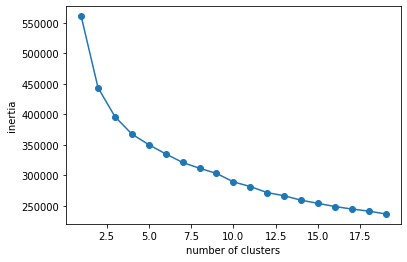

In [313]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_final_customer_df = std.fit_transform(final_customer_df)

n_clusters = range(1,20)
inertias = []
for k in n_clusters:
    model = KMeans(n_clusters = k)
    model.fit(std_final_customer_df)
    inertias.append(model.inertia_)
    
plt.plot(n_clusters, inertias, '-o')
plt.xlabel('number of clusters')
plt.ylabel('inertia')